# Implementing ANNs with TensorFlow - Homework 01

## Assignment: Implementing and Training an MLP

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

### Data

In [2]:
def generate_data():
    """
    This function loads preprocesses the digits dataset by rescaling the input images,
    one-hot encoding the targets, and finally shuffling the data.
    """
    # Load the data
    images, targets = load_digits(return_X_y = True)

    # Rescale the input images into [0, 1] range
    min_max_scaler = MinMaxScaler()
    rescaled_input = min_max_scaler.fit_transform(images)

    # One-hot encode the targets
    one_hot_target = np.array([[int(t == i) for i in range(10)] for _, t in enumerate(targets)])

    # Combine the processed data
    data = np.array([(i, t) for i, t in zip(rescaled_input, one_hot_target)], dtype = "object")

    # Shuffle the data
    rng = np.random.default_rng()
    rng.shuffle(data)

    return data

In [3]:
data = generate_data()

# Check the shape of the data
print(data.shape)

(1797, 2)


One-hot encoded target vector: [0 0 0 0 0 0 0 1 0 0]


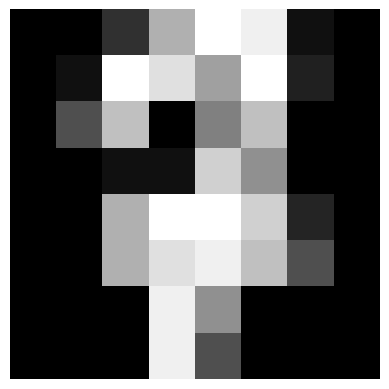

In [4]:
# Check if preprocessing worked out fine by comparing target vector and input image
print(f"One-hot encoded target vector: {data[0, 1]}")

# Plot the corresponding image
plt.imshow(data[0, 0].reshape(8,8), cmap="gray")
plt.axis("off")
plt.show()

In [5]:
def create_minibatches(dataset, batch_size):
    """
    This function creates and yields minibatches of input-target pairs in the given batch size.

    Arguments:
    dataset -- In this case, the preprocessed digits dataset
    batch_size -- Denotes the desired size of the minibatches
    """
    rng = np.random.default_rng()

    batch = rng.choice(dataset, size = batch_size, replace = False)

    yield np.stack(batch[:, 0]), np.stack(batch[:, 1])

### Activation functions & CCE loss

In [6]:
class Sigmoid:
    """
    Implements the Sigmoid activation function.
    """
    def __init__(self):
        pass

    def call(self, x):
        """
        Applies the sigmoid activation function to a vector of pre-activations (x).
        """
        return 1/(1 + np.exp(-x))

    def backward(self, x):
        """
        Returns the derivate of the Sigmoid function.
        """
        sigmoid = self.call(x)
        return (sigmoid * (1 - sigmoid))

In [7]:
class Softmax:
    """
    Implements the Softmax activation function.
    """
    def __init__(self):
        pass

    def call(self, z):
        """
        Applies the Softmax function to a vector of layer pre-activations (z).
        """
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=-1, keepdims=True)

    def backward(self, z):
        """
        Calculates the derivative of the Softmax function w.r.t. the vector z.
        """
        # Extract dimensions of z
        batch_size = z.shape[0]
        n = z.shape[1]

        # Create an array of identity matrices
        eye = np.dstack([np.eye(n)] * batch_size)

        # Calculate and combine the derivatives for every element in a batch
        return np.stack([(eye - z.T).T[i] * z[i] for i in range(batch_size)])

In [8]:
class CCELoss:
    """
    Implements the categorical cross-entropy loss function.
    """
    def __init__(self):
        pass

    def call(self, target, y_hat):
        """
        Calculates the CCE loss for a given prediction and target.

        Arguments:
        target -- The intended target for an image input
        y_hat -- The classification prediction made by the MLP
        """
        return -np.sum(target*np.log(y_hat), axis=-1)

    def backward(self, target, y_hat):
        """
        Returns a simplified derivate of the CCE loss. Arguments represent the same as above.
        """
        return -target/y_hat

### Multi-Layer Perceptron

In [9]:
class MLPLayer:
    """
    This class implements a single layer in the MLP.
    """
    def __init__(self, input_size, num_units, act_func):
        """
        Initializes the weights and biases of the network layer and defines its activation function
        and learning rate.

        Arguments:
        num_units -- Number of perceptrons in the network layer
        input_size -- Size of the input vector
        act_func -- Denotes which activation function will be applied
        """
        self.weights = np.random.normal(0, 0.2, (input_size, num_units))
        self.bias = np.zeros((1, num_units))
        self.act_func = act_func()
        self.learning_rate = 0.1

    def forward(self, input):
        """
        Propagates the input through the network.
        Returns the activations and pre-activations of the layer.

        Arguments:
        input -- Input vector to the respective network layer
        """
        pre_activation = input @ self.weights + self.bias
        activation = self.act_func.call(pre_activation)

        return activation, pre_activation

    def backward(self, input, error_signal):
        """
        Propagates the error signal from subsequent layer backwards to previous layer in the network.
        Returns the error signal for use in the previous network layer.

        Arguments:
        input -- Input vector to the respective network layer
        error_signal -- The error signal as passed down from subsequent network layer
        """
        batch_size = input.shape[0]
        activation, pre_activation = self.forward(input)

        # Calculate the error signal for the layer depending on the used activation function
        if isinstance(self.act_func, Softmax):
            error_signal = np.stack([error_signal[i] @ self.act_func.backward(activation)[i] for i in range(batch_size)])
        else:
            error_signal = error_signal * self.act_func.backward(pre_activation)

        # Calculate gradients w.r.t. weights and biases
        reshaped_input = [input.T[:,i].reshape((input.shape[1], 1)) for i in range(batch_size)]
        reshaped_error = [error_signal[i,:].reshape((1, error_signal.shape[1])) for i in range(batch_size)]
        d_W = np.mean([reshaped_input[i] * reshaped_error[i] for i in range(batch_size)], axis = 0)
        d_b = np.mean(error_signal, axis=0).reshape(self.bias.shape)

        # Propagate the error signal to previous layer
        error_signal = error_signal @ self.weights.T

        # Update weights and biases
        self.weights = self.weights - self.learning_rate * d_W
        self.bias = self.bias - self.learning_rate * d_b

        return error_signal

In [10]:
class MLP:
    """
    Implements the final Multi-Layer Perceptron as a combination of MLP layers.
    """
    def __init__(self, input_size, hidden_layer_sizes, output_layer_size):
        """
        Initializes a list of layers in the network.
        Hidden layers use Sigmoid activation functions, while the output layer uses a Softmax.

        Arguments:
        input_size -- Denotes the size of the flattened image vectors
        hidden_layer_sizes -- A list of the number of units in the hidden layers
        output_layer_size -- Number of perceptrons in the output layer
        """
        self.hidden_layers = []
        for idx, _ in enumerate(hidden_layer_sizes):
            if idx == 0:
                self.hidden_layers.append(MLPLayer(input_size, hidden_layer_sizes[idx], Sigmoid))
            else:
                self.hidden_layers.append(MLPLayer(hidden_layer_sizes[idx - 1], hidden_layer_sizes[idx], Sigmoid))
        self.output_layer = MLPLayer(hidden_layer_sizes[-1], output_layer_size, Softmax)

        self.layers = self.hidden_layers + [self.output_layer]

    def forward(self, input):
        """
        Returns the predictions made by the MLP.

        Argument:
        input -- Input vectors (or batches) of digit images
        """
        y_hat = [input]

        # Pass the input through the whole network
        for layer in self.layers:
            activation, _ = layer.forward(y_hat[-1])
            y_hat.append(activation)

        return y_hat

    def backward(self, y_hat, target):
        """
        Passes the error back through the network.

        Arguments:
        y_hat -- Predictions made by the MLP for a given image batch
        target -- The intended target for said image
        """
        # Extract predictions and batch size
        y_pred = y_hat[-1]
        batch_size = y_hat[0].shape[0]

        # Set a lower limit to prediction values
        y_pred = np.clip(y_pred, 1e-7, np.max(y_pred))

        # Calculate and backpropagate the error signal
        error_signal = CCELoss().backward(target, y_pred)

        for i in reversed(range(0, len(self.layers))):
            error_signal = self.layers[i].backward(y_hat[i], error_signal)

    def train(self, data, batch_size, epochs):
        """
        Trains the network by forwarding inputs and propagating errors backwards.
        Returns a list of recorded average losses per epoch for visualization.

        Arguments:
        data -- Preprocessed digits dataset
        batch_size -- Size of the mini-batches
        epochs -- Number of training iterations
        """
        error_list = []

        # Train the network for given number of epochs
        for i in range(epochs):
            epoch_loss = []

            # Create predictions and store losses for image-target pairs
            for image, target in create_minibatches(data, batch_size):

                y_hat = self.forward(image)
                self.backward(y_hat, target)

                loss = np.mean(CCELoss().call(target, y_hat[-1]))
                epoch_loss.append(loss)

            # Calculate and store mean loss for the current epoch
            avg_loss = np.mean(epoch_loss)
            error_list.append(avg_loss)

            # Show current CCE loss from time to time
            if (i == 0) | ((i + 1) % 5000 == 0):
                print(f"CCE loss after epoch {i+1}: {np.round(avg_loss, 3)}")

        return error_list

### Training the MLP

In [11]:
# Set training parameters
BATCH_SIZE = 32
EPOCHS = 50000

# Set number of units in hidden layers
hidden_layer_sizes = [32, 16]

# Instantiate the model
model = MLP(64, hidden_layer_sizes, 10)

# Train the model
losses = model.train(data, BATCH_SIZE, EPOCHS)

CCE loss after epoch 1: 2.357
CCE loss after epoch 5000: 0.111
CCE loss after epoch 10000: 0.042
CCE loss after epoch 15000: 0.027
CCE loss after epoch 20000: 0.051
CCE loss after epoch 25000: 0.009
CCE loss after epoch 30000: 0.011
CCE loss after epoch 35000: 0.003
CCE loss after epoch 40000: 0.007
CCE loss after epoch 45000: 0.007
CCE loss after epoch 50000: 0.012


### Visualization

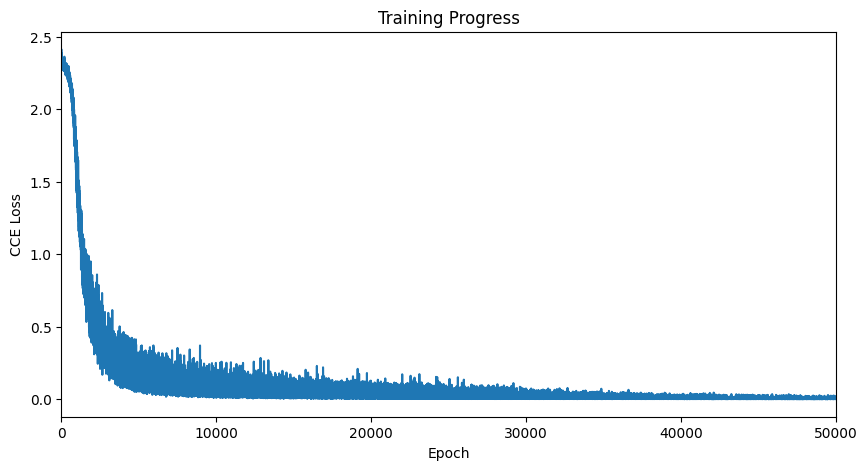

In [16]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(1, EPOCHS + 1), losses)
ax.set(title="Training Progress", xlabel="Epoch", ylabel="CCE Loss", xlim=[0, 50000])

plt.show()

As we can see, the training loss per epoch decreases significantly over time. The variance in the losses also diminishes towards the end of the model training.